In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from string import ascii_uppercase
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from wordcloud import WordCloud

sns.set(style="whitegrid")

In [2]:
# Functions for mapping BEET MGs, SMs and UGs

# Function to group the UGs into the SMs of BEET
def agrupar_ugs(ug):
    if ug in ['UG1', 'UG2']:
        return 'SM1'
    elif ug in ['UG3', 'UG4', 'UG5', 'UG6', 'UG7']:
        return 'SM2'
    elif ug in ['UG8', 'UG9']:
        return 'SM3'
    elif ug in ['UG10', 'UG11']:
        return 'SM4'
    elif ug in ['UG12', 'UG13']:
        return 'SM5'
    elif ug in ['UG14', 'UG15', 'UG16', 'UG17']:
        return 'SM6'
    elif ug in ['UG18', 'UG19']:
        return 'SM7'
    elif ug in ['UG20', 'UG21']:
        return 'SM8'
    elif ug in ['UG22', 'UG23', 'UG24']:
        return 'SM9'
    elif ug in ['UG25', 'UG26']:
        return 'SM10'
    elif ug in ['UG27', 'UG28']:
        return 'SM11'
    elif ug in ['UG29', 'UG30']:
        return 'SM12'
    elif ug in ['UG31', 'UG32']:
        return 'SM13'
    elif ug == 'UG33':
        return 'SM14'
    elif ug in ['UG34', 'UG35']:
        return 'SM15'
    else:
        return 'Unknown'


# Function to group the SMs into the major groups from BEET
def agrupar_sms(sm):
    if sm in ['SM1', 'SM2']:
        return 'MG1'
    elif sm in ['SM3', 'SM4']:
        return 'MG2'
    elif sm in ['SM5', 'SM6', 'SM7', 'SM8', 'SM9']:
        return 'MG3'
    elif sm in ['SM10', 'SM11', 'SM12']:
        return 'MG4'
    elif sm in ['SM13', 'SM14', 'SM15']:
        return 'MG5'
    else:
        return 'Unknown'

In [3]:
# Root pathname for original collected data
directory = 'data/'

# Reading the dataset
df = pd.read_excel(directory + "BEET-v2025-rev2.xlsx")
df

,Job Title (position),Job Description,Company Name,Company size,"Language (EN, ES, PT)",Country,Publication date (MM/YY),Category
0,Consulting Project Technical Manager,Job Description\n\nProject Management \nDirect...,Company A1,I,EN,JAPAN,11/24,UG31-IT-PROJECT-MANAGEMENT
1,Strategic Account Technology Specialist,Responsibilities\n\nYou orchestrate global tea...,Company B1,I,EN,USA,01/25,UG31-IT-PROJECT-MANAGEMENT
2,Solutions Consultant,"As a Solutions Consultant at Company C1, you w...",Company C1,F,EN,USA,01/25,UG31-IT-PROJECT-MANAGEMENT
3,Senior Solutions Consultant,As Sales Engineer/Solutions Consultant (Pre-Sa...,Company D1,I,EN,USA,02/25,UG31-IT-PROJECT-MANAGEMENT
4,IT Project Manager,"General Summary\n\nProvides budget analysis, r...",Company E1,I,EN,USA,02/25,UG31-IT-PROJECT-MANAGEMENT
...,...,...,...,...,...,...,...,...
384,"Sr. TIPM - Energy Market Strategist, Global Su...",\nDescription\n\nAt Company S2 we believe that...,Company S2,I,EN,USA,10/24,UG7-TECH-ENVIRONMENTALISM
385,Architecture Energy Modeling Engineer,"At Company Q1, we pride ourselves in having en...",Company Q1,I,EN,USA,10/24,UG7-TECH-ENVIRONMENTALISM
386,Energy Research Analyst,Company O8 is seeking a proactive and experien...,Company O8,I,EN,USA,01/25,UG7-TECH-ENVIRONMENTALISM
387,Wind Energy Analyst/Consultant,Looking for an opportunity to make an impact?\...,Company L9,I,EN,USA,01/25,UG7-TECH-ENVIRONMENTALISM


In [4]:
# Extracting the initial part of 'Category' before the '-' to have the UGs

df['UGs'] = df['Category'].str.split('-').str[0].str.strip()
df

,Job Title (position),Job Description,Company Name,Company size,"Language (EN, ES, PT)",Country,Publication date (MM/YY),Category,UGs
0,Consulting Project Technical Manager,Job Description\n\nProject Management \nDirect...,Company A1,I,EN,JAPAN,11/24,UG31-IT-PROJECT-MANAGEMENT,UG31
1,Strategic Account Technology Specialist,Responsibilities\n\nYou orchestrate global tea...,Company B1,I,EN,USA,01/25,UG31-IT-PROJECT-MANAGEMENT,UG31
2,Solutions Consultant,"As a Solutions Consultant at Company C1, you w...",Company C1,F,EN,USA,01/25,UG31-IT-PROJECT-MANAGEMENT,UG31
3,Senior Solutions Consultant,As Sales Engineer/Solutions Consultant (Pre-Sa...,Company D1,I,EN,USA,02/25,UG31-IT-PROJECT-MANAGEMENT,UG31
4,IT Project Manager,"General Summary\n\nProvides budget analysis, r...",Company E1,I,EN,USA,02/25,UG31-IT-PROJECT-MANAGEMENT,UG31
...,...,...,...,...,...,...,...,...,...
384,"Sr. TIPM - Energy Market Strategist, Global Su...",\nDescription\n\nAt Company S2 we believe that...,Company S2,I,EN,USA,10/24,UG7-TECH-ENVIRONMENTALISM,UG7
385,Architecture Energy Modeling Engineer,"At Company Q1, we pride ourselves in having en...",Company Q1,I,EN,USA,10/24,UG7-TECH-ENVIRONMENTALISM,UG7
386,Energy Research Analyst,Company O8 is seeking a proactive and experien...,Company O8,I,EN,USA,01/25,UG7-TECH-ENVIRONMENTALISM,UG7
387,Wind Energy Analyst/Consultant,Looking for an opportunity to make an impact?\...,Company L9,I,EN,USA,01/25,UG7-TECH-ENVIRONMENTALISM,UG7


In [5]:
df['SMs'] = df['UGs'].apply(agrupar_ugs)
df['MGs'] = df['SMs'].apply(agrupar_sms)

df

,Job Title (position),Job Description,Company Name,Company size,"Language (EN, ES, PT)",Country,Publication date (MM/YY),Category,UGs,SMs,MGs
0,Consulting Project Technical Manager,Job Description\n\nProject Management \nDirect...,Company A1,I,EN,JAPAN,11/24,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5
1,Strategic Account Technology Specialist,Responsibilities\n\nYou orchestrate global tea...,Company B1,I,EN,USA,01/25,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5
2,Solutions Consultant,"As a Solutions Consultant at Company C1, you w...",Company C1,F,EN,USA,01/25,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5
3,Senior Solutions Consultant,As Sales Engineer/Solutions Consultant (Pre-Sa...,Company D1,I,EN,USA,02/25,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5
4,IT Project Manager,"General Summary\n\nProvides budget analysis, r...",Company E1,I,EN,USA,02/25,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5
...,...,...,...,...,...,...,...,...,...,...,...
384,"Sr. TIPM - Energy Market Strategist, Global Su...",\nDescription\n\nAt Company S2 we believe that...,Company S2,I,EN,USA,10/24,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1
385,Architecture Energy Modeling Engineer,"At Company Q1, we pride ourselves in having en...",Company Q1,I,EN,USA,10/24,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1
386,Energy Research Analyst,Company O8 is seeking a proactive and experien...,Company O8,I,EN,USA,01/25,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1
387,Wind Energy Analyst/Consultant,Looking for an opportunity to make an impact?\...,Company L9,I,EN,USA,01/25,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1


## CLUSTERING

In [6]:
# Download NLTK resources

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


# Função de limpeza do texto
def clean_text(text):
    # Remover caracteres especiais e números
    text = re.sub(r'[^a-zA-Zá-úÁ-Ú\s]', '', text)
    text = text.lower()  # Converter para minúsculas
    return text


# Função para lematizar e remover stopwords
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('portuguese'))  # Ajustar para o idioma correto

    # Limpeza do texto
    text = clean_text(text)

    # Tokenização
    words = text.split()

    # Remover stopwords e lematizar as palavras restantes
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return " ".join(words)


# Função para obter as palavras mais relevantes de cada cluster
def get_top_keywords_for_cluster(cluster_label, n_top_words=50):
    # Extrair os índices dos documentos pertencentes ao cluster
    cluster_docs = np.where(model.labels_ == cluster_label)[0]
    
    # Obter a média dos valores de TF-IDF para os documentos do cluster
    cluster_tfidf = X[cluster_docs].mean(axis=0).A1  # A1 converte a matriz esparsa para array denso
    
    # Obter os índices das palavras mais relevantes
    top_indices = cluster_tfidf.argsort()[-n_top_words:][::-1]
    
    # Retornar as palavras mais relevantes
    return features[top_indices]


# Função para salvar as instâncias de cada cluster em um arquivo de texto
def save_cluster_instances(df, model, filename_prefix='cluster_instances'):
    # Cria um arquivo de texto para cada cluster
    for cluster_label in range(np.max(model.labels_) + 1):
        # Encontra as instâncias que pertencem ao cluster
        cluster_samples = np.where(model.labels_ == cluster_label)[0]
        
        # Cria um arquivo para salvar as instâncias do cluster
        with open(f"{filename_prefix}_cluster_{cluster_label}.txt", 'w') as f:
            f.write(f"Cluster {cluster_label}:\n\n")
            for sample in cluster_samples:
                job_title = df['Job Title (position)'].iloc[sample]
                job_description = df['Job Description'].iloc[sample]
                f.write(f"Job Title: {job_title}\n")
                f.write(f"Job Description: {job_description}\n\n")
                f.write("#################################################\n\n")
            f.write("\n")
            print(f"Cluster instances {cluster_label} saved in {filename_prefix}_cluster_{cluster_label}.txt")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jorgevalverde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jorgevalverde/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jorgevalverde/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
# Custom stopwords for our dataset
custom_stopwords = ['f1e', 'v6', 'q1', 'ps', 'l2', 'o2', 'u4', 'a1', 'd2', 'e1','s',
                   'k3', 't2','ec', 'bsc', 'g1', 'l4','p5' 'wellbeing', 'rol', 'roles',
                   'epic','u5', 'o8','ll', 'az', 'ops', 'card', '42001', 'q3', 'i9', 'q5', 
                    'ecu', 'coupled' , 'exposure', 'stage', 'food' ,'trajectory' ,'ingredient', 
                    'scenarios', 'pedestrians' , 'delighting', 'los' , 'angeles', 'flight', 'allow',
                    'p3', 'post', 'risks', 'minimize' , 'dl', 'threat' ,'osint', 'e8', 'ar' , 
                    'vr' , 'channel','s2', 'lustre' , 'x7' , 'infiniband', 'director', 'success', 
                    'corporate' , 'timing', 'grit' ,'european' ,'prize' ,'journey' ,  'role' , 
                    'fast', 'sr', 'delta' ,'forecasting' ,'outreach' ,'real', 'added', 'gympass', 
                    'completely' ,'wellness' ,'airflow', 'house', 'accessible', 'taking', 'like', 
                    'willing' , 'novel', 'barcelona', 'drizzle', 'experience' 'provides', 'emp',
                    'trino', 'elaboration' , 'day' , 'k4','similar', 'progressive' ,'customer' ,
                    'compensation', 'professional', 'calculator', 'services', 'demonstrated' , 
                    'reference', 'blogs', 'white', 'adoption', 'k4', 'sdic', 'depth' ,'emergent',
                    'passionately', 'sharp' , 'people', 'v2', 'invests' ,'bureau' ,'combo' ,
                    'selecting' ,'notice' ,'pays','percentage' ,'functional' ,'moves', 'protects', 
                    'hierarchical', 'invest', 'growth' ,'partners' ,'cutting', 'genuinely', 'best', 
                    'announce' ,'sleep', 'aspiring', 'therapy', 'deluge' , 'initiative' ,'sector' ,
                    'impactful', 'x5' , 'team' ,'macros' ,'dft', 'q1n' ,'brains' ,'immersed' ,
                    'tapping' 'fueled', 'prepare', 's6', 'o1' ,'company', 'health' ,'experience', 
                    'executives' , 'industry', 'avenues', 'dark', 'aperture', 'cloudy' ,'finland', 
                    'conferences' ,'alternative' , 'strong', 'work',  'preferred' , 'years', 
                    'proficiency' ,'specialty',  'b1' 'company', 'build' ,'largest', 'b1' ,'blue',
                    'prism','latest' ,'skills' 'theft', 'abuse' ,'combat', 'overview', 'r4', 
                    'language', 'skills' ,'instruments' ,'finance', 'problem' , 'effectively', 
                    'correction', 'areas', 'earth', 'observation', 'install' , 'hours', 
                    'experimentation' , 'end' ,'viability', 'raising' ,'amzl', 'tied', 'expense',
                    'delivering', 'capital' ,'north', 'utilities','utility' ,'escalate', 'blob' ,
                    'core', 'good', 'i1' , 'german', 'enriched', 'semi', 'motivations', 'non' ,
                    'consensus','ownership', 'way', 'naval', 'trips' ,'adjustments', 'concert' '48', 
                    'team', 'teams', 'resulted', 'range', 'j4', 'swrds', 'aaa', 'weak', 'dc' , 
                    'doing', 'telco', 'rightfax' ,'salespeople', '100' ,'pass', 'mission', 'new', 
                    'j5' , 'key' , 'causal', 'era', 'offers' ,'diverse' ,'profiling' ,'cutlass', 
                    'cute' , 'includes' ,'shaping', 'advancements' ,'millions', 'ideas', 'time', 
                    'truth' ,'varied' ,'whilst' ,'acquire' ,'priority','attendance' ,'appreciated' ,
                    'nearly', '600' ,'maritime', 'operates' , 'medicine' ,'export' ,'themself' ,
                    'nearby', 'able' ,'based', 'zones' , 'empower' , 'make', 'facilitate' ,'plus',
                    'financial', 'disciplinary',  'wework' ,'disruptors' ,'97001', 'send' , 'job' ,
                    'w1' ,'formal' 'needs' ,'authorized' ,'global' ,'output', 'proven', 'using', 
                    'ekf', 'ukf','construct', 'accept', 'fortnite' , 'player', 'e9', 'zkp' , 'zero',
                   'fhe' ,'zkps', 'express', 'city', 'w6', 'n5', '000', 'fund', 'expanded', 'expansion' ,
                    'reflects' ,'fitness', 'included','elevating' ,'nyc', '11' ,'opportunity', 'applicant',
                    'applicants', 'apply', 'brazil', 'news' ,'subscription', '2012', 'knit' ,'unmatched' ,
                    'having', 'integral','engaged', 'u1', 'small' ,'personnel' ,'define', 'medium' ,
                    'goals', 'capitalone' ,'endorse','reforma' ,'liable', 'marrying' ,'civil', 
                    'kingdom' ,'breakers' , 'mexico', 'posted', 'ciudad' ,'canada' ,'does',
                    'position' , 'religion', 'ot', 'q8', 'o5', 'expertise' , 'seen' , 'solving', 
                    'client',  'nasa' , 'improve', 'implement' ,'technical' ,'resolve' ,'storage', 
                    'related', 'entity',  'high', 'ability',  'world', 'plans' , 'plan', 'ability' ,
                    'internal', 'slam', 'degree' , 'design' , 'capabilities',  'camera', 'needs' , 
                    'case' , 'd1' , 'mldlc', 'bringup' , 'implement' , 'expect' , 'guarantee', 'makers' ,
                    'iccompany', 'j7', 'ensure', 'equal', 'p5', 'icm', 'actionable', 'is', 'at', 'c' ]  


# Concatenating English stopwords with our custom ones
all_stopwords = list(ENGLISH_STOP_WORDS) + custom_stopwords  # Convertendo para lista

In [8]:
# Preprocessing the textual column
df['cleaned_job_description'] = df['Job Description'].apply(preprocess_text)
df

,Job Title (position),Job Description,Company Name,Company size,"Language (EN, ES, PT)",Country,Publication date (MM/YY),Category,UGs,SMs,MGs,cleaned_job_description
0,Consulting Project Technical Manager,Job Description\n\nProject Management \nDirect...,Company A1,I,EN,JAPAN,11/24,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5,job description project management direct enga...
1,Strategic Account Technology Specialist,Responsibilities\n\nYou orchestrate global tea...,Company B1,I,EN,USA,01/25,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5,responsibility you orchestrate global team to ...
2,Solutions Consultant,"As a Solutions Consultant at Company C1, you w...",Company C1,F,EN,USA,01/25,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5,solution consultant at company c you will play...
3,Senior Solutions Consultant,As Sales Engineer/Solutions Consultant (Pre-Sa...,Company D1,I,EN,USA,02/25,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5,sale engineersolutions consultant presales you...
4,IT Project Manager,"General Summary\n\nProvides budget analysis, r...",Company E1,I,EN,USA,02/25,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5,general summary provides budget analysis resou...
...,...,...,...,...,...,...,...,...,...,...,...,...
384,"Sr. TIPM - Energy Market Strategist, Global Su...",\nDescription\n\nAt Company S2 we believe that...,Company S2,I,EN,USA,10/24,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1,description at company s we believe that every...
385,Architecture Energy Modeling Engineer,"At Company Q1, we pride ourselves in having en...",Company Q1,I,EN,USA,10/24,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1,at company q we pride ourselves in having ener...
386,Energy Research Analyst,Company O8 is seeking a proactive and experien...,Company O8,I,EN,USA,01/25,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1,company is seeking proactive and experienced e...
387,Wind Energy Analyst/Consultant,Looking for an opportunity to make an impact?\...,Company L9,I,EN,USA,01/25,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1,looking an opportunity to make an impact at co...


In [9]:
# Vetorização dos textos com TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=all_stopwords)
X = vectorizer.fit_transform(df['Job Description'])

# Obter as palavras do vocabulário
features = np.array(vectorizer.get_feature_names_out())

# Realizar o clustering hierárquico
linked = linkage(X.toarray(), method='ward')

# Aplicar AgglomerativeClustering para o agrupamento
model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.72)
model.fit(X.toarray())

# Obter as etiquetas de clusters atribuídas
df['Cluster'] = model.labels_
df

,Job Title (position),Job Description,Company Name,Company size,"Language (EN, ES, PT)",Country,Publication date (MM/YY),Category,UGs,SMs,MGs,cleaned_job_description,Cluster
0,Consulting Project Technical Manager,Job Description\n\nProject Management \nDirect...,Company A1,I,EN,JAPAN,11/24,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5,job description project management direct enga...,23
1,Strategic Account Technology Specialist,Responsibilities\n\nYou orchestrate global tea...,Company B1,I,EN,USA,01/25,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5,responsibility you orchestrate global team to ...,21
2,Solutions Consultant,"As a Solutions Consultant at Company C1, you w...",Company C1,F,EN,USA,01/25,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5,solution consultant at company c you will play...,21
3,Senior Solutions Consultant,As Sales Engineer/Solutions Consultant (Pre-Sa...,Company D1,I,EN,USA,02/25,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5,sale engineersolutions consultant presales you...,21
4,IT Project Manager,"General Summary\n\nProvides budget analysis, r...",Company E1,I,EN,USA,02/25,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5,general summary provides budget analysis resou...,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,"Sr. TIPM - Energy Market Strategist, Global Su...",\nDescription\n\nAt Company S2 we believe that...,Company S2,I,EN,USA,10/24,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1,description at company s we believe that every...,26
385,Architecture Energy Modeling Engineer,"At Company Q1, we pride ourselves in having en...",Company Q1,I,EN,USA,10/24,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1,at company q we pride ourselves in having ener...,26
386,Energy Research Analyst,Company O8 is seeking a proactive and experien...,Company O8,I,EN,USA,01/25,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1,company is seeking proactive and experienced e...,26
387,Wind Energy Analyst/Consultant,Looking for an opportunity to make an impact?\...,Company L9,I,EN,USA,01/25,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1,looking an opportunity to make an impact at co...,8


In [10]:
# Display the most relevant words for each cluster
for cluster_label in range(np.max(model.labels_) + 1):
    print(f"Cluster {cluster_label}: {get_top_keywords_for_cluster(cluster_label)}")


Cluster 0: ['software' 'development' 'architecture' 'solutions' 'applications'
 'business' 'data' 'mobile' 'cloud' 'application' 'engineering'
 'technologies' 'systems' 'knowledge' 'product' 'code' 'working' 'java'
 'projects' 'quality' 'digital' 'architect' 'practices' 'web' 'develop'
 'requirements' 'management' 'support' 'complex' 'products' 'provide'
 'including' 'platform' 'solution' 'building' 'iot' 'technology'
 'security' 'communication' 'enterprise' 'engineers' 'standards'
 'processes' 'environment' 'developing' 'lead' 'agile' 'developer'
 'qualifications' 'level']
Cluster 1: ['power' 'verification' 'soc' 'cryptography' 'cryptographic' 'chip' 'ip'
 'knowledge' 'rtl' 'silicon' 'analog' 'architecture' 'hardware' 'uvm'
 'engineer' 'coverage' 'verilog' 'working' 'digital' 'electrical'
 'analysis' 'systems' 'electronics' 'protocols' 'synthesis' 'socs' 'vpu'
 'formal' 'compiler' 'cryptographers' 'products' 'development'
 'performance' 'proofs' 'isa' 'simulation' 'general' 'framework

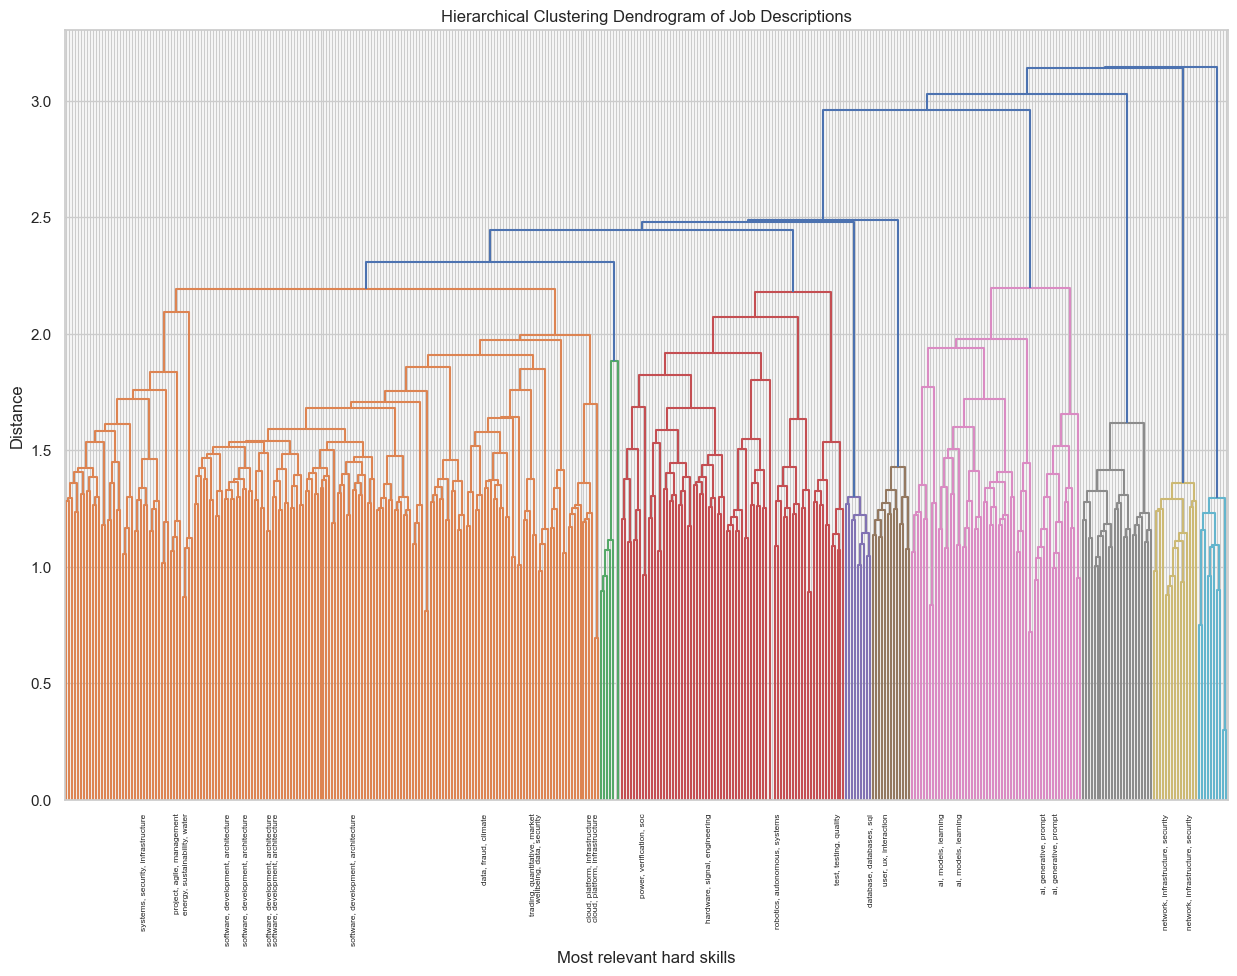

In [11]:
# Plotar o dendrograma com as palavras mais relevantes nas folhas
plt.figure(figsize=(15, 10))

labels = [', '.join(get_top_keywords_for_cluster(label, 3)) for label in model.labels_]
step = max(1, len(labels) // 23)  # Exibir apenas algumas labels
filtered_labels = [label if i % step == 0 else '' for i, label in enumerate(labels)]

dendrogram(
    linked,
    labels=filtered_labels,
    orientation='top',
    distance_sort='descending',
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=0.7 * max(linked[:, 2]),  # Define um threshold para cores
    show_leaf_counts=True
)

plt.gca().set_facecolor('none')  # Remove o fundo cinza do gráfico
plt.gcf().set_facecolor('none')  # Remove o fundo da figura
plt.xticks(fontsize=6)  # Diminui o tamanho da fonte para evitar sobreposição


plt.title("Hierarchical Clustering Dendrogram of Job Descriptions")
plt.xlabel("Most relevant hard skills")
plt.ylabel("Distance")
plt.savefig("figs/BEET-dendogram.png", format="png", bbox_inches="tight", transparent=True)
plt.show()

In [12]:
save_cluster_instances(df, model, filename_prefix='clusters/cluster_instances')

Cluster instances 0 saved in clusters/cluster_instances_cluster_0.txt
Cluster instances 1 saved in clusters/cluster_instances_cluster_1.txt
Cluster instances 2 saved in clusters/cluster_instances_cluster_2.txt
Cluster instances 3 saved in clusters/cluster_instances_cluster_3.txt
Cluster instances 4 saved in clusters/cluster_instances_cluster_4.txt
Cluster instances 5 saved in clusters/cluster_instances_cluster_5.txt
Cluster instances 6 saved in clusters/cluster_instances_cluster_6.txt
Cluster instances 7 saved in clusters/cluster_instances_cluster_7.txt
Cluster instances 8 saved in clusters/cluster_instances_cluster_8.txt
Cluster instances 9 saved in clusters/cluster_instances_cluster_9.txt
Cluster instances 10 saved in clusters/cluster_instances_cluster_10.txt
Cluster instances 11 saved in clusters/cluster_instances_cluster_11.txt
Cluster instances 12 saved in clusters/cluster_instances_cluster_12.txt
Cluster instances 13 saved in clusters/cluster_instances_cluster_13.txt
Cluster inst

In [13]:
# Measuring clustering quality

# Verificar se há pelo menos 2 clusters antes de calcular o silhouette score
n_clusters = len(set(model.labels_))  # Conta quantos clusters existem

if n_clusters > 1:
    silhouette_avg = silhouette_score(X.toarray(), model.labels_)
    print(f"Silhouette Score: {silhouette_avg:.4f}")

    db_index = davies_bouldin_score(X.toarray(), model.labels_)
    print(f"Davies-Bouldin Index: {db_index:.4f}")

    ch_score = calinski_harabasz_score(X.toarray(), model.labels_)
    print(f"Calinski-Harabasz Score: {ch_score:.4f}")
else:
    print("It is not possible to calculate the Silhouette Score, Davies-Bouldin Index, or Calinski-Harabasz Score with only one cluster.")


Silhouette Score: 0.0470
Davies-Bouldin Index: 3.3704
Calinski-Harabasz Score: 2.9119


## Wordcloud

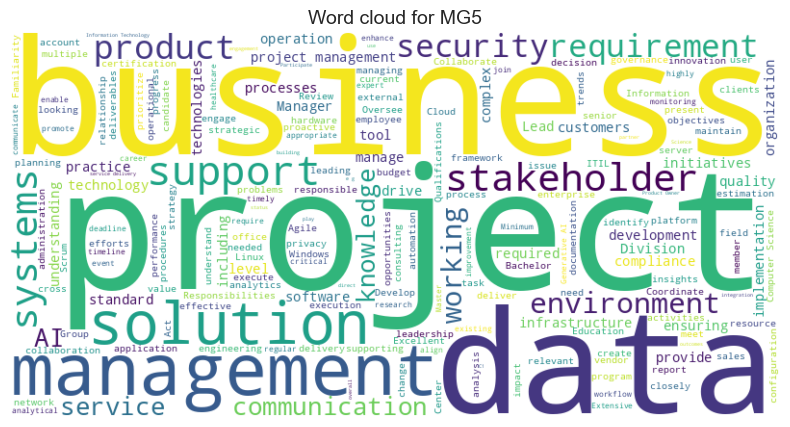

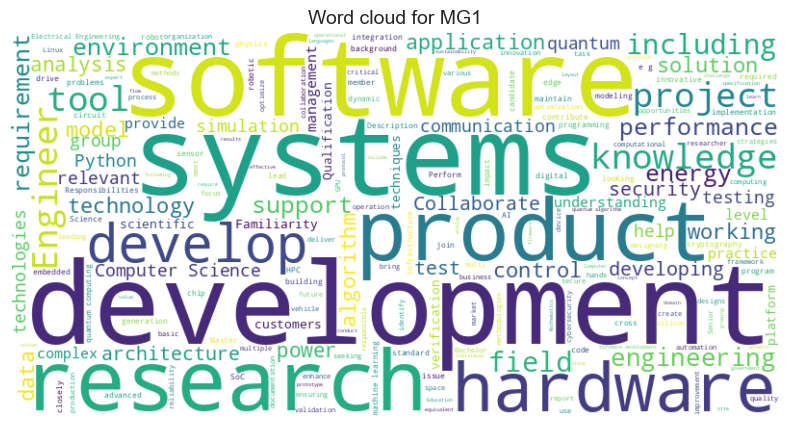

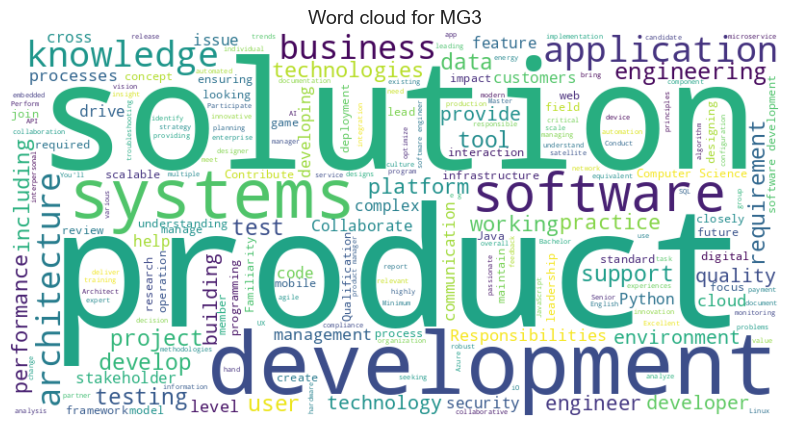

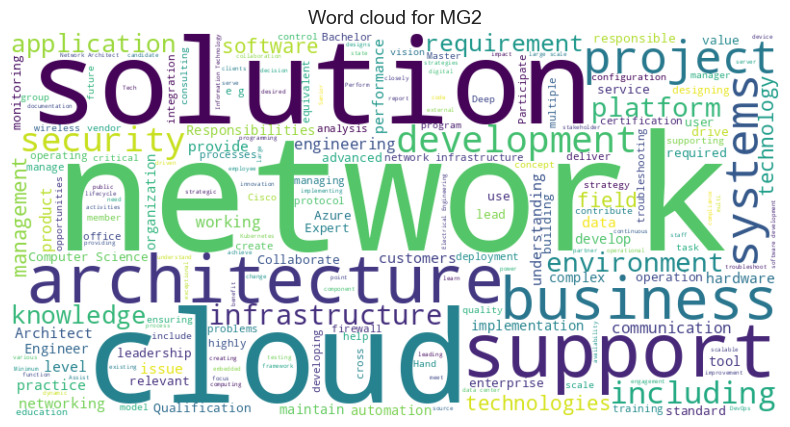

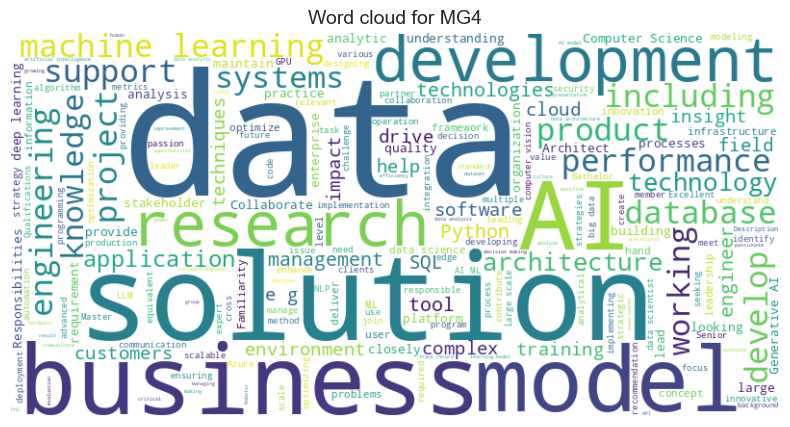

In [14]:
# Criar nuvem de palavras para cada grupo único de SM
unique_sms = df['MGs'].unique()

for mg in unique_sms:
    # Filtrar as instâncias do DataFrame que pertencem ao SM atual
    df_filtered = df[df['MGs'] == mg]
    
    # Concatenar todas as descrições de trabalho do grupo SM em um único texto
    text = ' '.join(df_filtered['Job Description'].astype(str))
    
    # Gerar a nuvem de palavras
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                          stopwords=all_stopwords, max_words=200).generate(text)
    
    # Plotar a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word cloud for {mg}", fontsize=14)
    plt.savefig(f"figs/BEET-wordcloud-{mg}.png", format="png", bbox_inches="tight")
    plt.show()

## Exploring data

/var/folders/gg/vns8r5652zxg31hm4l2cdym40000gp/T/ipykernel_40046/3188465490.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


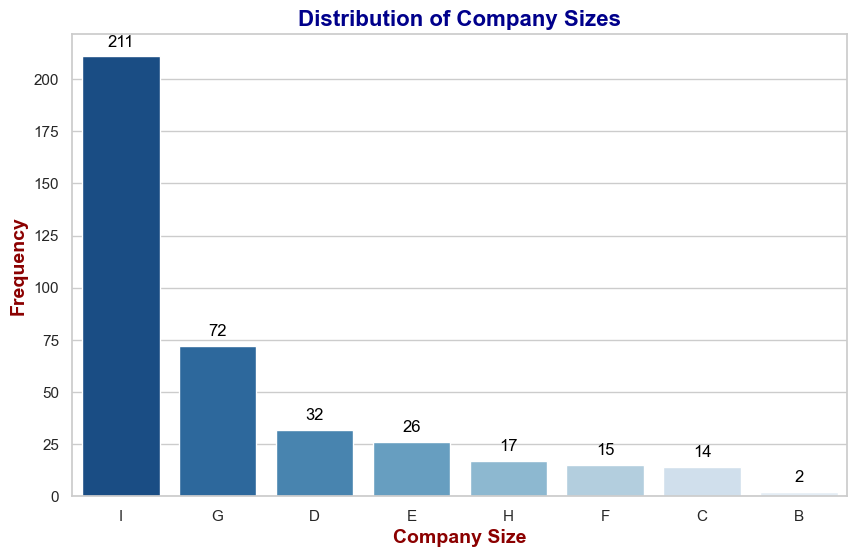

In [15]:
# Criando a figura
plt.figure(figsize=(10, 6))

# Criando o gráfico de barras
ax = sns.countplot(
    data=df, 
    x='Company size', 
    order=df['Company size'].value_counts().index,
    palette='Blues_r'  # Usando uma paleta de cores agradáveis
)

# Melhorando título e rótulos com fontes mais impactantes
plt.title('Distribution of Company Sizes', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Company Size', fontsize=14, fontweight='semibold', color='darkred')
plt.ylabel('Frequency', fontsize=14, fontweight='semibold', color='darkred')

# Adicionando os valores nas barras para facilitar a leitura
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5, fontsize=12, color='black')

plt.savefig("figs/BEET-company_size_plot.png", format="png", bbox_inches="tight")
plt.show()

In [16]:
# Filtering the top-N companies by number of job postings
N = 10
top_N_companies = df['Company Name'].value_counts().nlargest(N) 
top_N_df = df[df['Company Name'].isin(top_N_companies.index)]
top_N_df

,Job Title (position),Job Description,Company Name,Company size,"Language (EN, ES, PT)",Country,Publication date (MM/YY),Category,UGs,SMs,MGs,cleaned_job_description,Cluster
1,Strategic Account Technology Specialist,Responsibilities\n\nYou orchestrate global tea...,Company B1,I,EN,USA,01/25,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5,responsibility you orchestrate global team to ...,21
6,Division IT Manager,The Biotechnology and Human Systems Division s...,Company G1,G,EN,USA,10/24,UG31-IT-PROJECT-MANAGEMENT,UG31,SM13,MG5,the biotechnology and human system division se...,8
8,IT Service Manager,Your mission will be… \n\nWe are looking for a...,Company I1,I,EN,PORTUGAL,02/25,UG32-IT-SERVICE-MANAGEMENT,UG32,SM13,MG5,your mission will be we are looking an it serv...,8
14,Digital Layout Design Engineer,Do you have a passion for crafting entirely ne...,Company O1,I,EN,USA,10/24,UG1-CIRCUITS-DEVICES,UG1,SM1,MG1,you have passion crafting entirely new solutio...,5
16,Senior Circuit Design Engineer,Company Q1 has been redefining computer graphi...,Company Q1,I,EN,USA,09/24,UG1-CIRCUITS-DEVICES,UG1,SM1,MG1,company q ha been redefining computer graphic ...,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,"TIPM, Energy & Water, RME Global Energy Infras...",\nAt Company S2 we believe that Every Day is s...,Company S2,I,EN,USA,11/24,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1,at company s we believe that every day is stil...,26
382,"Sr. Program Manager - Utility Services, Energ...",\nCompany S2 is looking for a Program Manager ...,Company S2,I,EN,USA,10/24,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1,company s is looking program manager to join t...,8
383,"Technical Infrastructure Program Manager, HVAC...","\nDescription\n\nAt Company S2, we believe tha...",Company S2,I,EN,USA,10/24,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1,description at company s we believe that every...,8
384,"Sr. TIPM - Energy Market Strategist, Global Su...",\nDescription\n\nAt Company S2 we believe that...,Company S2,I,EN,USA,10/24,UG7-TECH-ENVIRONMENTALISM,UG7,SM2,MG1,description at company s we believe that every...,26


/var/folders/gg/vns8r5652zxg31hm4l2cdym40000gp/T/ipykernel_40046/2584183289.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


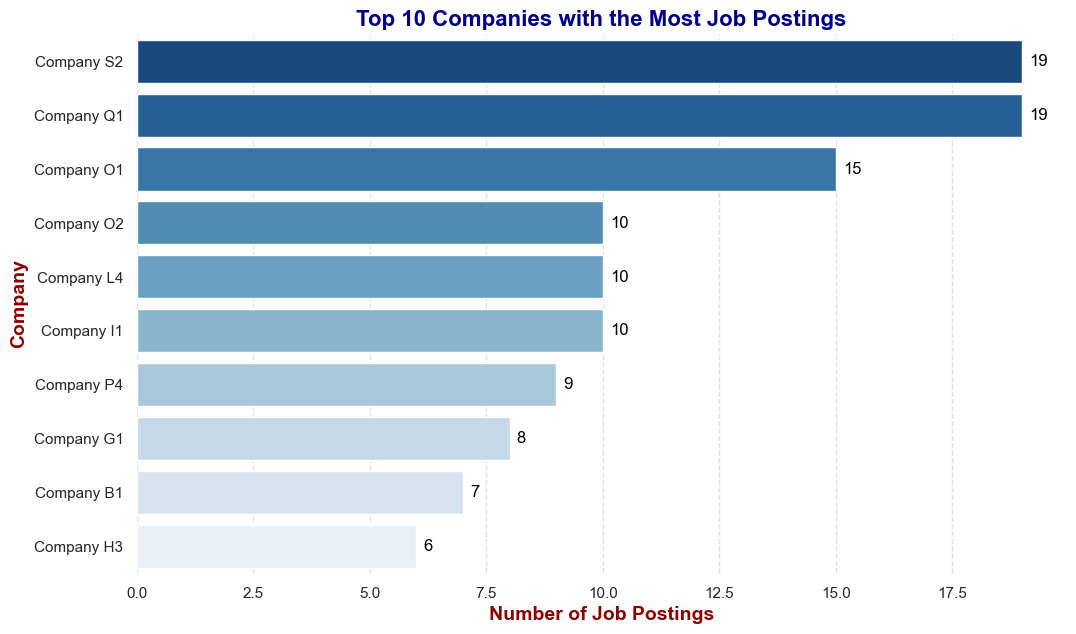

In [17]:
# Criando a figura
plt.figure(figsize=(12, 7))

# Criando o gráfico de barras ordenado
ax = sns.countplot(
    data=top_N_df, 
    y='Company Name', 
    order=top_N_companies.index,  # Corrigimos o problema aqui
    palette='Blues_r'
)

# Melhorando título e rótulos
plt.title(f'Top {N} Companies with the Most Job Postings', fontsize=16, fontweight='bold',color='darkblue')
plt.xlabel('Number of Job Postings', fontsize=14, fontweight='semibold', color='darkred')
plt.ylabel('Company', fontsize=14, fontweight='semibold', color='darkred')

# Adicionando os valores nas barras
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5, fontsize=12, color='black')

# Removendo bordas desnecessárias e melhorando visualização
sns.despine(left=True, bottom=True)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Salvando o gráfico em PDF
plt.savefig("figs/BEET-top10-companies_plot.png", format="png", bbox_inches="tight")

plt.show()

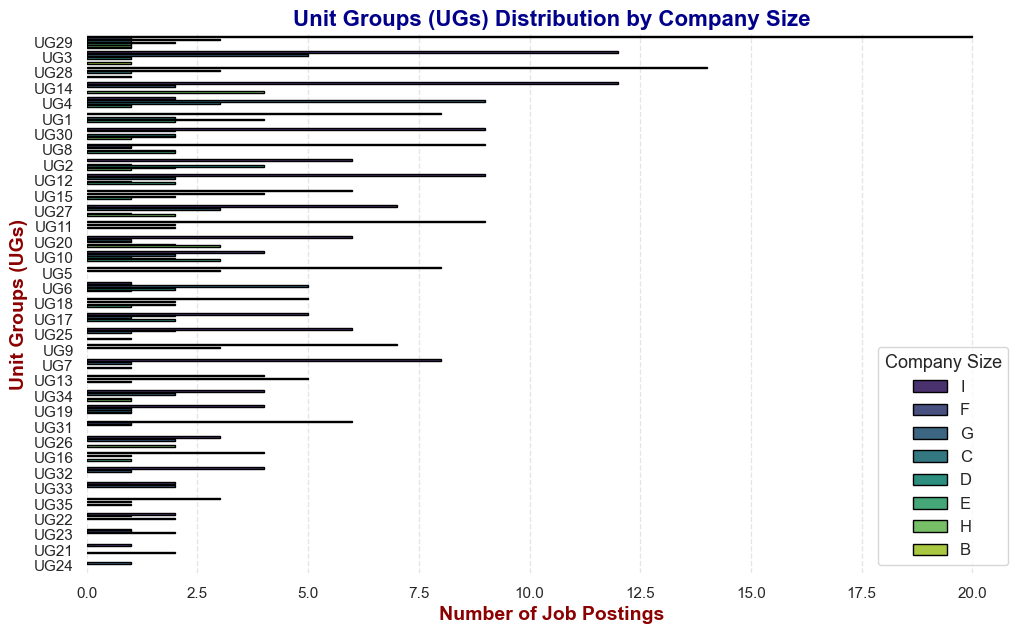

In [18]:
plt.figure(figsize=(12, 7))

ax = sns.countplot(
    data=df, 
    y='UGs',  # Alteramos para barras horizontais
    hue='Company size', 
    order=df['UGs'].value_counts().index, 
    palette='viridis',  
    edgecolor='black'  
)

plt.title('Unit Groups (UGs) Distribution by Company Size', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Number of Job Postings', fontsize=14, fontweight='semibold', color='darkred')
plt.ylabel('Unit Groups (UGs)', fontsize=14, fontweight='semibold', color='darkred')

plt.legend(title='Company Size', loc='lower right', fontsize=12, title_fontsize=13, frameon=True)
plt.grid(axis='x', linestyle='--', alpha=0.5)
sns.despine(left=True, bottom=True)
plt.savefig("figs/BEET-unit-group-company-distribution.png", format="png", bbox_inches="tight")
plt.show()


/var/folders/gg/vns8r5652zxg31hm4l2cdym40000gp/T/ipykernel_40046/3873834991.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


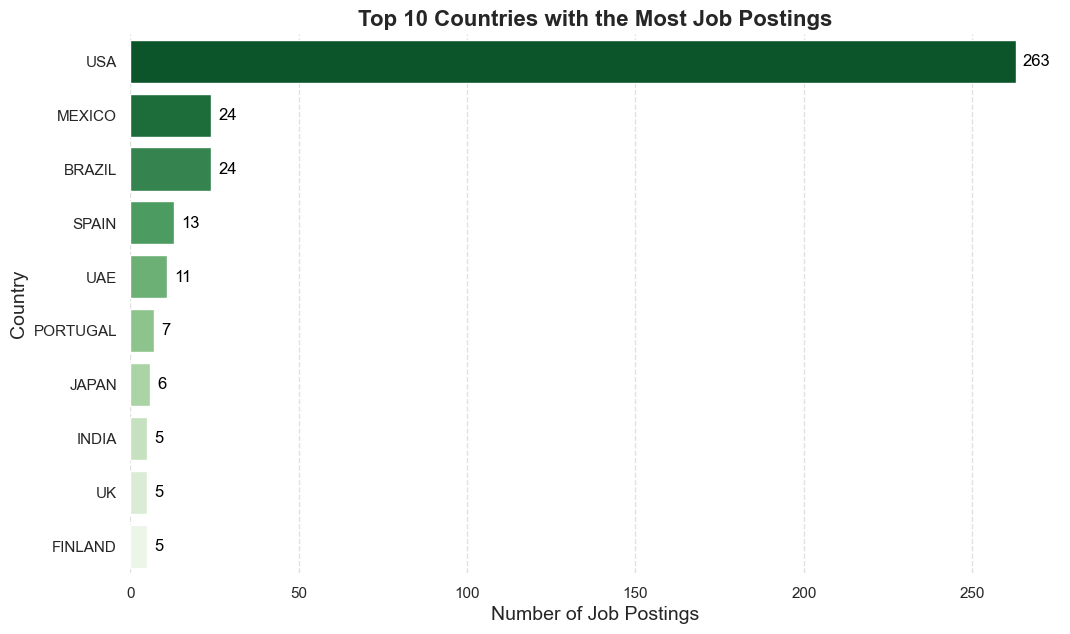

In [19]:
# Contagem de vagas por país, pegando apenas o TOP 10
top_10_countries = df['Country'].value_counts().nlargest(10)

# Criando a figura
plt.figure(figsize=(12, 7))

# Criando o gráfico de barras ordenado
ax = sns.barplot(
    y=top_10_countries.index, 
    x=top_10_countries.values, 
    palette='Greens_r'
)

# Melhorando título e rótulos
plt.title('Top 10 Countries with the Most Job Postings', fontsize=16, fontweight='bold')
plt.xlabel('Number of Job Postings', fontsize=14)
plt.ylabel('Country', fontsize=14)

# Adicionando os valores nas barras
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5, fontsize=12, color='black')

# Melhorando visualização
sns.despine(left=True, bottom=True)
plt.grid(axis='x', linestyle='--', alpha=0.6)


plt.savefig("figs/BEET-top10-countries_plot.png", format="png", bbox_inches="tight")

# Exibindo o gráfico
plt.show()

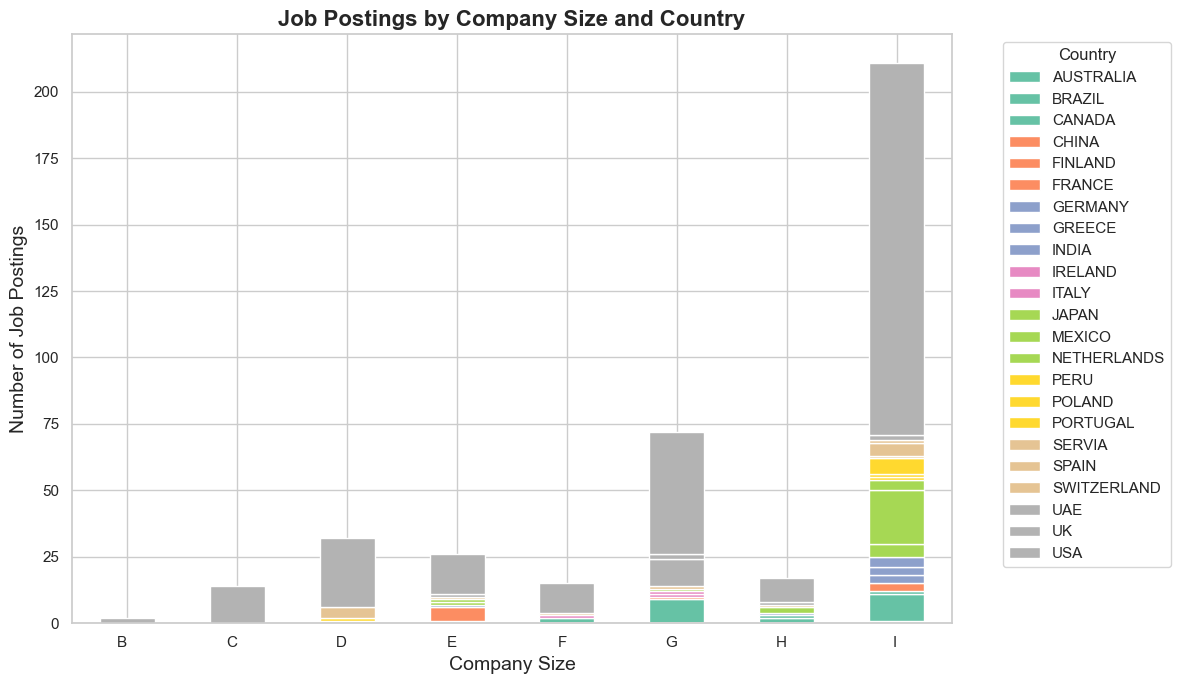

In [20]:
# Agrupando os dados por 'Company size' e 'Country' e contando as vagas
proporcao_vagas = df.groupby(['Company size', 'Country']).size().unstack(fill_value=0)

# Criando o gráfico de barras empilhadas
proporcao_vagas.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Set2')

# Melhorando título e rótulos
plt.title('Job Postings by Company Size and Country', fontsize=16, fontweight='bold')
plt.xlabel('Company Size', fontsize=14)
plt.ylabel('Number of Job Postings', fontsize=14)
plt.xticks(rotation=0, ha='right')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Exibindo o gráfico
plt.tight_layout()

plt.savefig("figs/BEET-company-sizes-countries_plot.png", format="png", bbox_inches="tight")

plt.show()


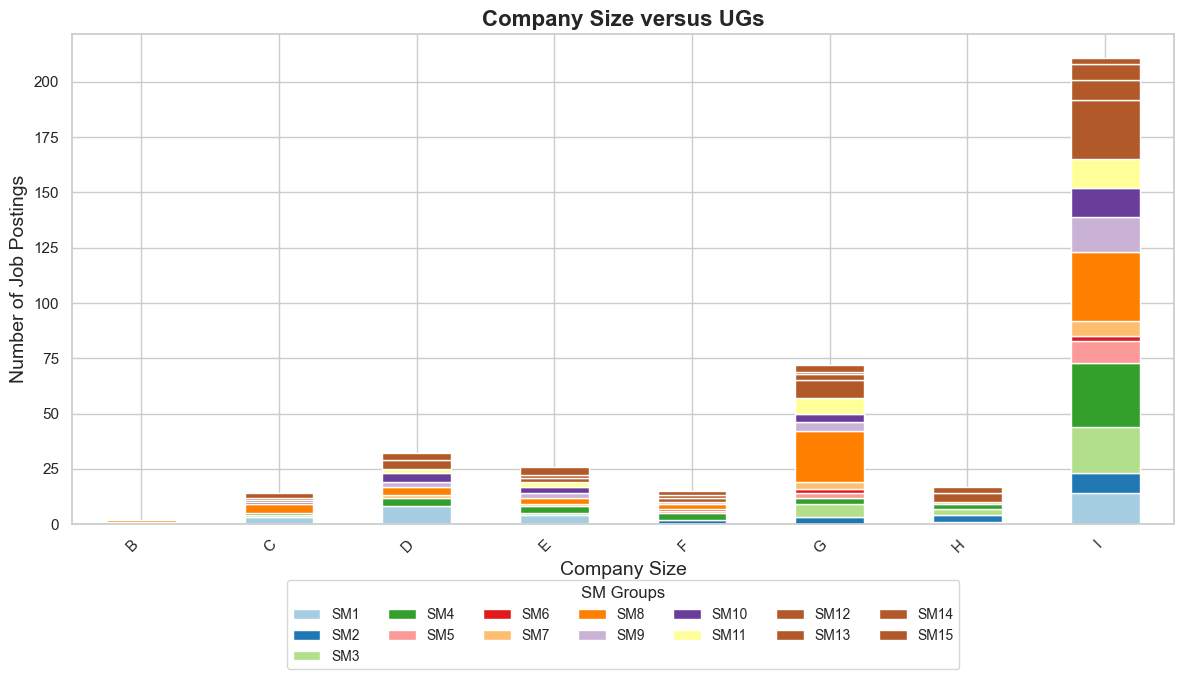

In [21]:
# Agrupando os dados por 'Company size' e 'SMs' e contando o número de vagas
relacao_tamanho_ug = df.groupby(['Company size', 'SMs']).size().unstack(fill_value=0)

# Cores únicas para cada SM
colors = plt.cm.Paired(range(15))

# Criando o gráfico de barras
ax = relacao_tamanho_ug.plot(kind='bar', stacked=True, figsize=(12, 7), color=colors)

# Melhorando título e rótulos
plt.title('Company Size versus UGs', fontsize=16, fontweight='bold')
plt.xlabel('Company Size', fontsize=14)
plt.ylabel('Number of Job Postings', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Ajustando a legenda para ficar na parte inferior e estendida
plt.legend(title='SM Groups', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=7, fontsize=10, labels=[f'SM{i}' for i in range(1, 16)])

# Exibindo o gráfico
plt.tight_layout()

plt.savefig("figs/BEET-company-sizes-UGs_plot.png", format="png", bbox_inches="tight")

plt.show()
